# Read Data

In [1]:
import os
import pickle
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

def read_prune(fn_csv):
    return pd.read_csv(f'prune_bsol/{fn_csv}', dtype={'bsol': 'str'})

def flip_bsol(bsol:str) -> str:
    # ensure that the bsol starts with 0
    if bsol[0] == '1':
        return ''.join(['0' if c == '1' else '1' for c in bsol])
    return bsol

def read_prune_all() -> pd.DataFrame:
    fn_pkl = 'df_prune.pkl'
    if os.path.exists(fn_pkl):
        print('Loading df_prune.pkl')
        with open(fn_pkl, 'rb') as f:
            return pickle.load(f)
        
    csv_files = [fn for fn in os.listdir('prune_bsol') if fn.endswith('.csv')]

    # with ProcessPoolExecutor() as executor:
    #     data = list(tqdm(executor.map(read_prune, csv_files), total=len(csv_files)))
    
    data = []
    for file in tqdm(csv_files):
        data.append(read_prune(file))

    df = pd.concat(data, ignore_index=True)

    # 
    df['bsol'] = df['bsol'].apply(flip_bsol)

    df['len_bsol'] = df['bsol'].apply(len)

    df['constraint'] = df.apply(lambda x: f"{x['i_name']} {x['j'] - x['i']} {x['j_name']}", axis=1)

    # save as pickle
    print('Saving df_prune.pkl')
    with open('df_prune.pkl', 'wb') as f:
        pickle.dump(df, f)
    return df

df_prune = read_prune_all()
df_prune.columns

Loading df_prune.pkl


Index(['i', 'j', 'i_name', 'j_name', 'i_residue_number', 'j_residue_number',
       'dij', 'bsol', 'len_bsol', 'constraint'],
      dtype='object')

# Constraint analysis

In [2]:
def create_df_stats(df_prune:pd.DataFrame, max_length=20) -> pd.DataFrame:
    # frequency relative taking into account the length of the bsol
    df_relfreq = df_prune[['len_bsol','bsol','dij']].groupby(['len_bsol','bsol']).count().reset_index()
    # rename columns
    df_relfreq.rename(columns={'dij':'count'}, inplace=True)
    # total number of bsol for each length
    df_relfreq['total'] = df_relfreq.groupby('len_bsol')['count'].transform('sum')
    # frequency relative
    df_relfreq['relfreq'] = df_relfreq['count'] / df_relfreq['total']
    # sort by length and frequency relative
    df_relfreq.sort_values(['len_bsol','relfreq'], ascending=[True,False], inplace=True)
    # length as string
    df_relfreq['length'] = df_relfreq['len_bsol'].astype(str)
    # uniform distribution
    # the first bit is fixed to 0 (flip), so the dof is 2^(len_bsol - 1)
    df_relfreq['uniform'] = 1.0 / (2 ** (df_relfreq['len_bsol'] - 1))
    # keep only the instances with len_bsol <= 20
    df_relfreq = df_relfreq[df_relfreq['len_bsol'] <= max_length]
    return df_relfreq

df_stats = create_df_stats(df_prune)
print(df_stats.shape)
df_stats.head(10)

(8258, 7)


,len_bsol,bsol,count,total,relfreq,length,uniform
1,2,01,1015891,1458773,0.696401,2,0.500
0,2,00,442882,1458773,0.303599,2,0.500
5,4,0011,515092,1442468,0.357091,4,0.125
7,4,0101,208964,1442468,0.144866,4,0.125
4,4,0010,183661,1442468,0.127324,4,0.125
9,4,0111,165758,1442468,0.114913,4,0.125
3,4,0001,137198,1442468,0.095113,4,0.125
6,4,0100,101013,1442468,0.070028,4,0.125
2,4,0000,68403,1442468,0.047421,4,0.125
8,4,0110,62379,1442468,0.043245,4,0.125


In [3]:
import plotly.express as px

# scatter, x=len_bsol, y=count, y axis log scale
def plot_count_by_length(df_stats:pd.DataFrame):
    df = df_stats[['len_bsol', 'length', 'total']].groupby(['len_bsol','length']).first().reset_index()
    fig = px.scatter(df, x='length', y='total', log_y=True,
                     title=f"Number of BSOLs",)
    # set size
    fig.update_layout(width=800, height=400)
    fig.show()

plot_count_by_length(df_stats)

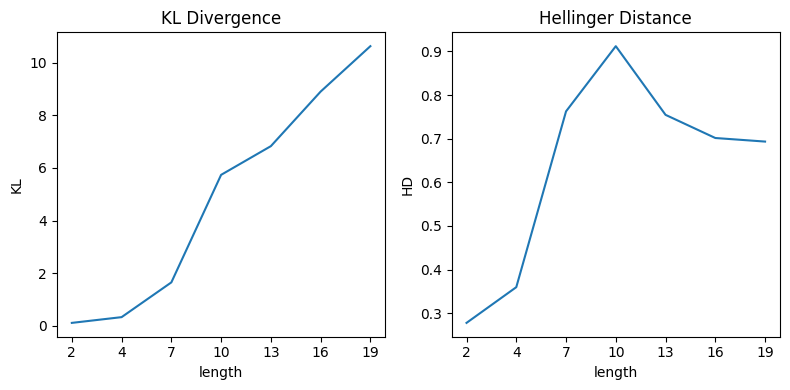

In [4]:
import numpy as np

def plot_stats_measures(df_stats:pd.DataFrame) -> pd.DataFrame:
    # measure KL divergence
    # KL(p||q) = sum(p(x) * log(p(x) / q(x))), where q(x) = 1/2^(len_bsol - 1)
    # Note: 
    #   - The function q is the uniform distribution over all possible BSOLs of length len_bsol.
    #   - The minus 1 is because the first bit is fixed to 0.
    df = df_stats.copy()
    df['KL'] = df_stats.apply(lambda x: x['relfreq'] * np.log2(x['relfreq'] / x['uniform']), axis=1)
    # measure Hellinger distance
    df['HD'] = df_stats.apply(lambda x: np.sqrt(0.5 * (x['relfreq'] - x['uniform']) ** 2), axis=1)
    # sum KL and HD for each length
    df = df.groupby(['len_bsol','length']).sum().reset_index()

    # plot KL, HD, TV using subplots 1 x 3, each one should have its own y axis
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sns.lineplot(x='length', y='KL', data=df, ax=axs[0])
    axs[0].set_title('KL Divergence')
    sns.lineplot(x='length', y='HD', data=df, ax=axs[1])
    axs[1].set_title('Hellinger Distance')    
    plt.tight_layout()
    plt.show()
    

plot_stats_measures(df_stats)

# Constraint by type

In [6]:
def create_df_stats_by_constraint(df_prune:pd.DataFrame, max_length:int=20) -> pd.DataFrame:
    # frequency relative taking into account the length of the bsol
    df_relfreq = df_prune[['len_bsol','bsol','constraint','dij']].groupby(['constraint','bsol','len_bsol']).count().reset_index()
    # rename columns
    df_relfreq.rename(columns={'dij':'count'}, inplace=True)
    # total number of bsol for each length
    df_relfreq['total'] = df_relfreq.groupby('constraint')['count'].transform('sum')
    # frequency relative
    df_relfreq['relfreq'] = df_relfreq['count'] / df_relfreq['total']
    # sort by length and frequency relative
    df_relfreq.sort_values(['len_bsol','constraint','relfreq'], ascending=[True,True,False], inplace=True)
    # length as string
    df_relfreq['length'] = df_relfreq['len_bsol'].astype(str) # help plots as string
    # uniform distribution
    # the first bit is fixed to 0 (flip), so the dof is 2^(len_bsol - 1)
    df_relfreq['uniform'] = 1.0 / (2 ** (df_relfreq['len_bsol'] - 1))
    # keep only the instances with len_bsol <= 20
    df_relfreq = df_relfreq[df_relfreq['len_bsol'] <= max_length]
    return df_relfreq

In [7]:
df_stats = create_df_stats_by_constraint(df_prune)
df_stats.head(20)

,constraint,bsol,len_bsol,count,total,relfreq,length,uniform
0,C 4 CA,00,2,442822,766210,0.577938,2,0.500
1,C 4 CA,01,2,323388,766210,0.422062,2,0.500
120179,N 4 CA,01,2,692503,692563,0.999913,2,0.500
120178,N 4 CA,00,2,60,692563,0.000087,2,0.500
41598,H 6 H,0011,4,406792,692535,0.587396,4,0.125
41597,H 6 H,0010,4,135250,692535,0.195297,4,0.125
41600,H 6 H,0101,4,100337,692535,0.144884,4,0.125
41599,H 6 H,0100,4,50104,692535,0.072349,4,0.125
41596,H 6 H,0001,4,16,692535,0.000023,4,0.125
41601,H 6 H,0110,4,14,692535,0.000020,4,0.125


In [8]:
def plot_cumulative_relfreq(constraint, df_stats):
    """
    Plots the cumulative relative frequency for a given constraint from a DataFrame.

    Parameters:
    - constraint (str): The constraint to filter the DataFrame on.
    - df_stats (pd.DataFrame): The DataFrame containing the statistics.

    This function filters the DataFrame based on the given constraint, calculates the cumulative
    relative frequency, and plots the results for two methods: FBS and DFS.
    """
    # Filter the DataFrame based on the constraint and sort by 'relfreq'
    df = df_stats[df_stats['constraint'] == constraint].sort_values('relfreq', ascending=False).reset_index(drop=True)
    
    # Sort the DataFrame by 'bsol' for DFS method
    dfDFS = df.sort_values(['bsol'], ascending=True).reset_index(drop=True)
    
    # Calculate cumulative relative frequency and assign method and order for FBS
    df['cumsum_relfreq'] = df['relfreq'].cumsum()
    df['method'] = 'FBS'
    df['order'] = df.index + 1

    # Calculate cumulative relative frequency and assign method and order for DFS
    dfDFS['cumsum_relfreq'] = dfDFS['relfreq'].cumsum()
    dfDFS['method'] = 'DFS'
    dfDFS['order'] = dfDFS.index + 1
    
    # Concatenate the DataFrames for FBS and DFS methods
    df = pd.concat([df, dfDFS], ignore_index=True)

    # Plotting
    import plotly.express as px
    fig = px.line(df, x='order', y='cumsum_relfreq', color='method', title=f"Constraint: {constraint}",
                  labels={'order':'Order', 'cumsum_relfreq':'Cumulative Relative Frequency', 'method':'Method'})
    fig.update_layout(width=600, height=400)
    fig.show()

plot_cumulative_relfreq('HA 6 HA', df_stats)

In [9]:
def len_common_prefix(b1:str, b2:str) -> int:
    for k in range(len(b1)):
        if b1[k] != b2[k]:
            return k
    return k

def expected_cost_dfs(bsol:list, relfreq:list, sort:bool=True):
    b_old = 'x' * len(bsol[0])
    expected_cost = 0.0
    num_changed_bits = 0
    len_bsol = len(bsol[0])
    # sort the bsol by decreasing frequency
    bsol_freq = list(zip(bsol, relfreq))
    if sort:
         bsol_freq = sorted(list(zip(bsol, relfreq)), key=lambda x: x[0], reverse=False)
    for b, f in bsol_freq:
        # count the number of changed bits until reaching the current bsol
        num_changed_bits += len_bsol - len_common_prefix(b_old, b)
        # update the expected cost
        expected_cost += num_changed_bits * f
        # update the old bsol
        b_old = b
    return expected_cost

def expected_cost_fbs(len_bsol:int, relfreq:list):
    relfreq = sorted(relfreq, reverse=True)    
    expected_cost = 0.0
    for k, f in enumerate(relfreq):        
        # update the expected cost
        expected_cost += ((k + 1) * len_bsol) * f
    return expected_cost

In [10]:
import numpy as np
from copy import deepcopy

def greedy_fbs_order(bsol:list, relfreq:list) -> int:
    bsol_freq = sorted(list(zip(bsol, relfreq)), key=lambda x: x[1], reverse=True)
    order = [(b, f, np.inf) for b, f in bsol_freq]
    len_bsol = len(bsol[0])
    for k1 in range(len(order) - 1):
        b1, _, _ = order[k1]
        min_rel_cost = np.inf
        for k2 in range(k1 + 1, len(order)):
            b2, f2, _ = order[k2]
            bit_cost = (len_bsol - len_common_prefix(b1, b2)) / len_bsol
            rel_cost = (1 - f2) * bit_cost
            if rel_cost < min_rel_cost:
                min_rel_cost = rel_cost
                min_k2 = k2
        # swap the elements
        if min_k2 == k1 + 1:
            order[min_k2] = (order[min_k2][0], order[min_k2][1], min_rel_cost)
        else:
            bfc = deepcopy(order[k1 + 1])
            order[k1 + 1] = (order[min_k2][0], order[min_k2][1], min_rel_cost)
            order[min_k2] = bfc
    return order

In [11]:
constraint = 'H 6 H'
df = df_stats[df_stats['constraint'] == constraint].reset_index(drop=True)
display(df)

fbs_greedy = greedy_fbs_order(df['bsol'], df['relfreq'])
bsol = [bfc[0] for bfc in fbs_greedy]
relfreq = [bfc[1] for bfc in fbs_greedy]

cost_dfs = expected_cost_dfs(df['bsol'], df['relfreq'])
cost_fbs = expected_cost_fbs(len(df['bsol'][0]), df['relfreq'])
cost_fbs_greedy = expected_cost_dfs(bsol, relfreq, sort=False)

print('constraint:', constraint)
print(f"Expected cost for DFS ......... {cost_dfs:.2f}")
print(f"Expected cost for FBS ......... {cost_fbs:.2f}")
print(f"Expected cost for FBS greedy .. {cost_fbs_greedy:.2f}")

,constraint,bsol,len_bsol,count,total,relfreq,length,uniform
0,H 6 H,0011,4,406792,692535,0.587396,4,0.125
1,H 6 H,0010,4,135250,692535,0.195297,4,0.125
2,H 6 H,0101,4,100337,692535,0.144884,4,0.125
3,H 6 H,0100,4,50104,692535,0.072349,4,0.125
4,H 6 H,0001,4,16,692535,0.000023,4,0.125
5,H 6 H,0110,4,14,692535,0.000020,4,0.125
6,H 6 H,0111,4,13,692535,0.000019,4,0.125
7,H 6 H,0000,4,9,692535,0.000013,4,0.125


constraint: H 6 H
Expected cost for DFS ......... 8.60
Expected cost for FBS ......... 6.81
Expected cost for FBS greedy .. 5.79


In [12]:
import plotly.express as px

# scatter, x=len_bsol, y=count, y axis log scale
def plot_count_by_length(df_stats:pd.DataFrame):
    df = df_stats[['len_bsol', 'constraint', 'total']].groupby(['len_bsol','constraint']).first().reset_index()
    fig = px.scatter(df, x='constraint', y='total', log_y=True,
                     title=f"Number of BSOLs",)
    # set size
    fig.update_layout(width=800, height=400)
    fig.show()

plot_count_by_length(df_stats)

C:\Users\romul\AppData\Local\Temp\ipykernel_15044\3754924799.py:27: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\romul\AppData\Local\Temp\ipykernel_15044\3754924799.py:27: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



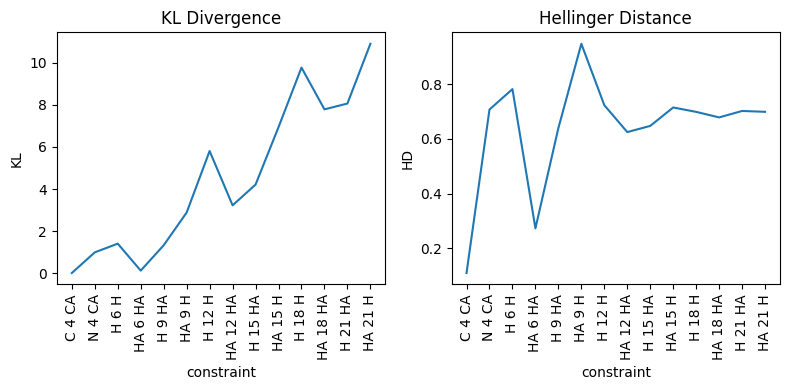

In [13]:
import numpy as np

def plot_stats_measures(df_stats:pd.DataFrame) -> pd.DataFrame:
    # measure KL divergence
    # KL(p||q) = sum(p(x) * log(p(x) / q(x))), where q(x) = 1/2^(len_bsol - 1)
    # Note: 
    #   - The function q is the uniform distribution over all possible BSOLs of length len_bsol.
    #   - The minus 1 is because the first bit is fixed to 0.
    df = df_stats.copy()
    df['KL'] = df_stats.apply(lambda x: x['relfreq'] * np.log2(x['relfreq'] / x['uniform']), axis=1)
    # measure Hellinger distance
    df['HD'] = df_stats.apply(lambda x: np.sqrt(0.5 * (x['relfreq'] - x['uniform']) ** 2), axis=1)
    # sum KL and HD for each length
    df = df.groupby(['len_bsol','constraint']).sum().reset_index()

    # plot KL, HD, TV using subplots 1 x 3, each one should have its own y axis
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sns.lineplot(x='constraint', y='KL', data=df, ax=axs[0])
    axs[0].set_title('KL Divergence')
    sns.lineplot(x='constraint', y='HD', data=df, ax=axs[1])
    axs[1].set_title('Hellinger Distance')

    for tick in axs:
        tick.set_xticklabels(labels=tick.get_xticklabels(), rotation=90)

    # plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()
    

plot_stats_measures(df_stats)

# Analysis of independent constraints

In [27]:
import pandas as pd

def fix_repeated_atom_bit(row: pd.Series) -> str:
    constraint_start = row["constraint"].split(" ")[0]
    bsol = list(row["bsol"])
    constraint_length = len(bsol) 

    #  in the re-order, a repeated CA dist 6 atoms to the next repeated CA
    step_repeatedCA = 6

    # index of the first repeated CA supposing the first three atoms of the constraint are fixed and.
    i_repeatedCA = 0
    if constraint_start == 'H':
        i_repeatedCA = 2
    elif constraint_start == 'HA':
        i_repeatedCA = 5
    else:
        return "".join(x for x in bsol)

    for i in range(i_repeatedCA, constraint_length, step_repeatedCA):
        if bsol[i] == '0':
            bsol[i] = '1'
    
    a = "".join(x for x in bsol)
    return a

df_independent = df_stats.copy()
df_independent["bsol"] = df_stats.apply(fix_repeated_atom_bit, axis=1)

,constraint,bsol,len_bsol,count,total,relfreq,length,uniform
0,C 4 CA,00,2,442822,766210,0.577938,2,0.500000
1,C 4 CA,01,2,323388,766210,0.422062,2,0.500000
120179,N 4 CA,01,2,692503,692563,0.999913,2,0.500000
120178,N 4 CA,00,2,60,692563,0.000087,2,0.500000
41598,H 6 H,0011,4,406792,692535,0.587396,4,0.125000
...,...,...,...,...,...,...,...,...
67281,HA 21 H,0111101111100110101,19,1,201532,0.000005,19,0.000004
67284,HA 21 H,0111101111101000100,19,1,201532,0.000005,19,0.000004
67287,HA 21 H,0111101111101010100,19,1,201532,0.000005,19,0.000004
67291,HA 21 H,0111101111101101101,19,1,201532,0.000005,19,0.000004


,constraint,bsol,len_bsol,count,total,relfreq,length,uniform
0,C 4 CA,00,2,442822,766210,0.577938,2,0.500000
1,C 4 CA,01,2,323388,766210,0.422062,2,0.500000
120179,N 4 CA,01,2,692503,692563,0.999913,2,0.500000
120178,N 4 CA,00,2,60,692563,0.000087,2,0.500000
41598,H 6 H,0011,4,406792,692535,0.587396,4,0.125000
...,...,...,...,...,...,...,...,...
67281,HA 21 H,0111111111110110111,19,1,201532,0.000005,19,0.000004
67284,HA 21 H,0111111111111000110,19,1,201532,0.000005,19,0.000004
67287,HA 21 H,0111111111111010110,19,1,201532,0.000005,19,0.000004
67291,HA 21 H,0111111111111101111,19,1,201532,0.000005,19,0.000004


In [28]:
constraint = 'H 6 H'
df = df_independent[df_independent['constraint'] == constraint].reset_index(drop=True)
display(df)

fbs_greedy = greedy_fbs_order(df['bsol'], df['relfreq'])
bsol = [bfc[0] for bfc in fbs_greedy]
relfreq = [bfc[1] for bfc in fbs_greedy]

cost_dfs = expected_cost_dfs(df['bsol'], df['relfreq'])
cost_fbs = expected_cost_fbs(len(df['bsol'][0]), df['relfreq'])
cost_fbs_greedy = expected_cost_dfs(bsol, relfreq, sort=False)

print('constraint:', constraint)
print(f"Expected cost for DFS ......... {cost_dfs:.2f}")
print(f"Expected cost for FBS ......... {cost_fbs:.2f}")
print(f"Expected cost for FBS greedy .. {cost_fbs_greedy:.2f}")

,constraint,bsol,len_bsol,count,total,relfreq,length,uniform
0,H 6 H,0011,4,406792,692535,0.587396,4,0.125
1,H 6 H,0010,4,135250,692535,0.195297,4,0.125
2,H 6 H,0111,4,100337,692535,0.144884,4,0.125
3,H 6 H,0110,4,50104,692535,0.072349,4,0.125
4,H 6 H,0011,4,16,692535,0.000023,4,0.125
5,H 6 H,0110,4,14,692535,0.000020,4,0.125
6,H 6 H,0111,4,13,692535,0.000019,4,0.125
7,H 6 H,0010,4,9,692535,0.000013,4,0.125


constraint: H 6 H
Expected cost for DFS ......... 6.77
Expected cost for FBS ......... 6.81
Expected cost for FBS greedy .. 5.57
